In [54]:
import typing as t

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.ndimage.filters import convolve
from scipy.stats import ks_2samp

# add src to path
sys.path.append('../..')
from utils.db_helper import get_image_data
from utils.color_space_operations import get_difference_img_gen, calculate_difference_image

In [55]:
GRAYSCALE=False
base_save_path=base_save_path = os.path.join("..", "..", "..", "exp", "Histograms")


In [56]:
SOURCE_DIR_STYLE = R"F:\master-thesis-databases\classification_db\fake"
SOURCE_DIR_FFHQ = R"F:\master-thesis-databases\classification_db\real"

In [57]:
def hist_peek_point(np_img: np.ndarray, bins=256, hist_range=(0,255), channels=9)-> t.Tuple[float, int]:
    peek_points = []
    for colorspace in range(channels):
        np_hist, bins = np.histogram(np_img[:,:,colorspace], density=True, bins=bins, range=hist_range)
        y = np_hist.max()
        idx = np.argwhere(np_hist==y)
        
        if len(idx)>1:
            idx = int(idx[-1])
        else:
            idx = int(idx)
        x = int(bins[idx])

        peek_points.append((x,y))
    return peek_points

In [58]:
def peek_points_from_diff_dataset(dataset_gen: t.Generator[np.ndarray, None, None], bins=511, max_number_of_images=10, grayscale=False)-> t.Tuple[t.List[float], t.List[int]]:
    print("Processing database...")
    peek_points = []
    for np_img in dataset_gen:
        x = hist_peek_point(np_img)
        peek_points.append(x)
    return peek_points

# Peek points

In [59]:
color_components = ("R", "G", "B", "H", "S", "V", "Y", "Cb", "Cr")
categories = ['real', 'fake']
GRAYSCALE=False
kernel = "diff"
# kernel = "grad"

In [60]:
ffhq_gen = get_image_data(SOURCE_DIR_FFHQ, type='float', grayscale=False, max_number_of_images=100)
style_gen = get_image_data(SOURCE_DIR_STYLE, type='float', grayscale=False, max_number_of_images=100)

FFHQ_peek_points = peek_points_from_diff_dataset(get_difference_img_gen(ffhq_gen, kernel=kernel),  max_number_of_images=10, grayscale=GRAYSCALE)
Style_peek_points = peek_points_from_diff_dataset(get_difference_img_gen(style_gen, kernel=kernel), max_number_of_images=10, grayscale=GRAYSCALE)

Processing database...
len: 100
Processing database...
len: 100


In [61]:
np_FFHQ_peek_points = np.asarray(FFHQ_peek_points)
np_Style_peek_points = np.asarray(Style_peek_points)

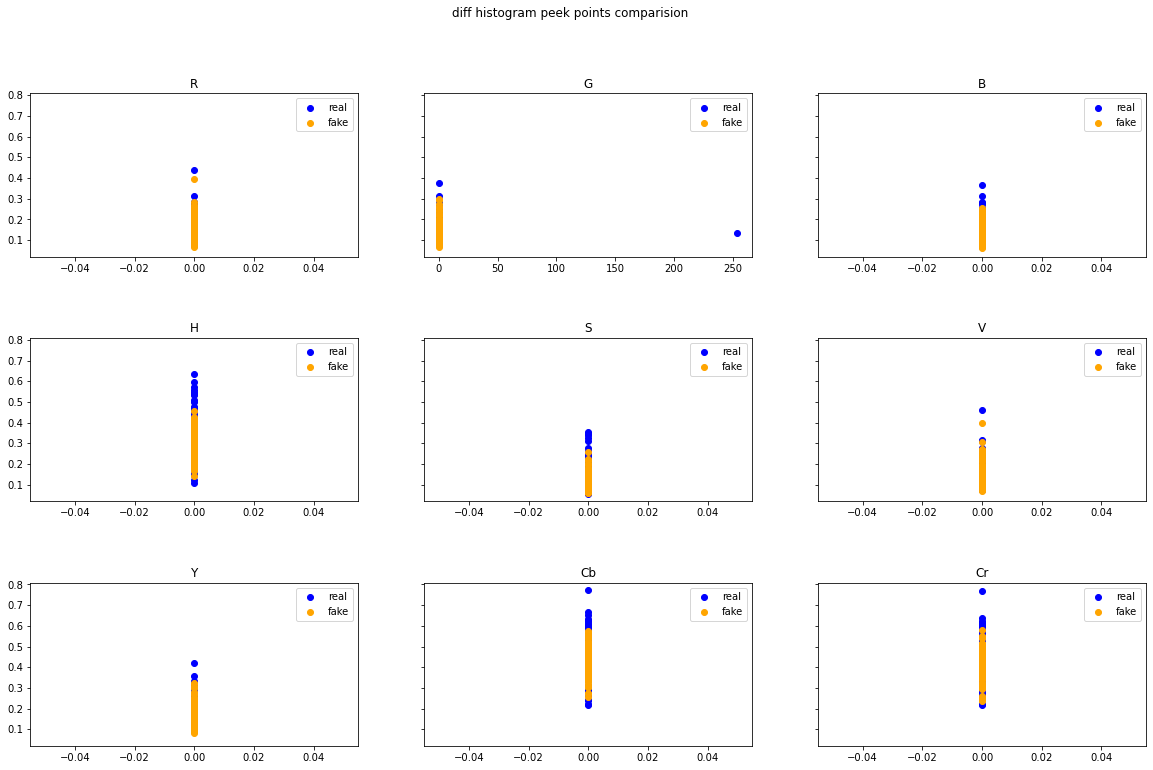

In [64]:
fig, axs = plt.subplots(ncols=3, nrows=3, sharey=True, figsize=(20,12))
fig.suptitle(f'{kernel} histogram peek points comparision')
plt.subplots_adjust(hspace=0.5)

for colorspace in range(len(color_components)):
    axs[int(colorspace/3),colorspace%3].scatter(np_FFHQ_peek_points[:,colorspace,0], np_FFHQ_peek_points[:,colorspace,1], color='blue', label=categories[0])
    axs[int(colorspace/3),colorspace%3].scatter(np_Style_peek_points[:,colorspace,0], np_Style_peek_points[:,colorspace,1], color='orange', label=categories[1])
    axs[int(colorspace/3),colorspace%3].legend(['real', 'fake'])
    axs[int(colorspace/3),colorspace%3].set_title(color_components[colorspace])

plt.show()
savepath = os.path.join(base_save_path, f"Peek_point_comparision_{kernel}.png")
# fig.savefig(savepath)

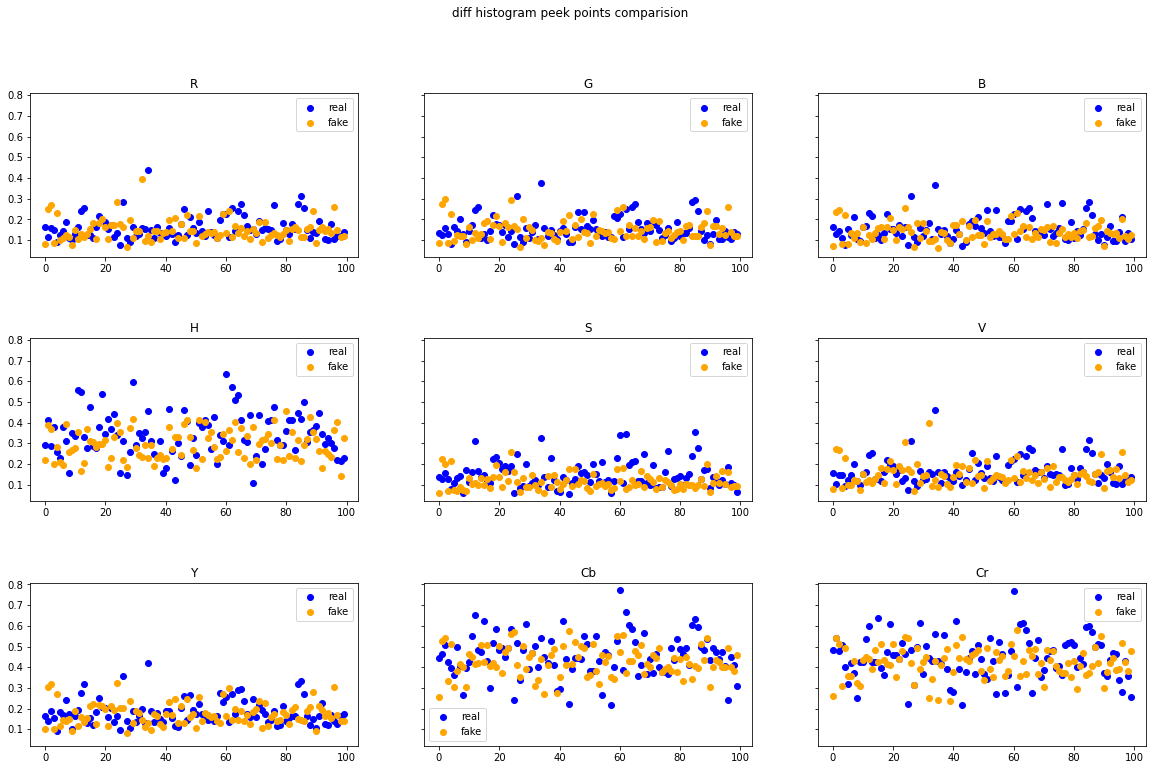

In [66]:
fig, axs = plt.subplots(ncols=3, nrows=3, sharey=True, figsize=(20,12))
fig.suptitle(f'{kernel} histogram peek points comparision')
plt.subplots_adjust(hspace=0.5)

for colorspace in range(len(color_components)):
    axs[int(colorspace/3),colorspace%3].scatter(range(100), np_FFHQ_peek_points[:,colorspace,1], color='blue', label=categories[0])
    axs[int(colorspace/3),colorspace%3].scatter(range(100), np_Style_peek_points[:,colorspace,1], color='orange', label=categories[1])
    axs[int(colorspace/3),colorspace%3].legend(['real', 'fake'])
    axs[int(colorspace/3),colorspace%3].set_title(color_components[colorspace])

plt.show()
savepath = os.path.join(base_save_path, f"Peek_point_comparision_{kernel}_alt.png")
fig.savefig(savepath)

## Kolmogorov-Smirnoff test for color componenets

In [49]:
save_path = os.path.join(base_save_path, "peek_points_diff+kstest.csv")

In [50]:
results = []
for colorspace in range(len(color_components)):
    x_ks_test =  ks_2samp(np_FFHQ_peek_points[:,colorspace, 0], np_Style_peek_points[:,colorspace, 0])
    y_ks_test =  ks_2samp(np_FFHQ_peek_points[:,colorspace, 1], np_Style_peek_points[:,colorspace, 1])
    results.append((color_components[colorspace], x_ks_test, y_ks_test))


In [52]:
df_results = pd.DataFrame(results, columns=["Color_component", "X", "Y"])
# df_results.to_csv(save_path)
df_results

,Color_component,X,Y
0,R,"(0.18, 0.07822115797841851)","(0.25, 0.0037294923618311367)"
1,G,"(0.15, 0.21117008625127576)","(0.22, 0.015577131622877688)"
2,B,"(0.17, 0.11119526053829192)","(0.25, 0.0037294923618311367)"
3,H,"(0.19, 0.05390207893129876)","(0.22, 0.015577131622877688)"
4,S,"(0.28, 0.0007377026282063397)","(0.21, 0.024055802841094577)"
5,V,"(0.19, 0.05390207893129876)","(0.26, 0.002219935934558366)"
6,Y,"(0.1, 0.7020569828664881)","(0.22, 0.015577131622877688)"
7,Cb,"(0.17, 0.11119526053829192)","(0.21, 0.024055802841094577)"
8,Cr,"(0.17, 0.11119526053829192)","(0.18, 0.07822115797841851)"
